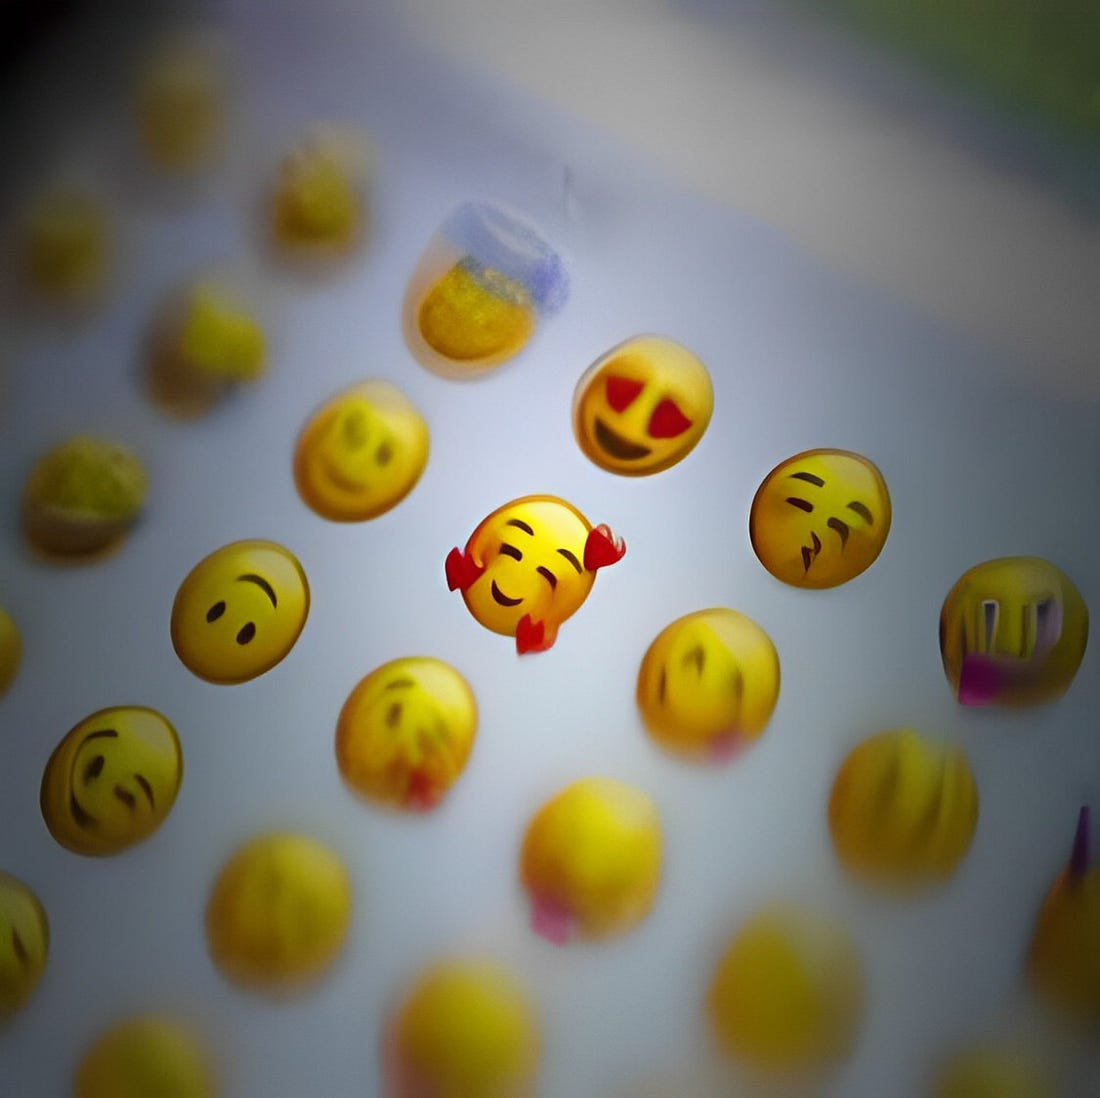

 BERT (Bidirectional Encoder Representations from Transformers) have shown impressive results in various natural language processing tasks. However, the standard BERT model has a size of over 400 MB, which makes it difficult to deploy in mobile or web applications with limited resources.
 
 To address this challenge, researchers have introduced a new model called **MobileBERT**, which has a much smaller size (less than 100 MB) and can perform similar to BERT with minimal changes in accuracy

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emotion-dataset/validation.csv
/kaggle/input/emotion-dataset/training.csv
/kaggle/input/emotion-dataset/test.csv
/kaggle/input/contractions/contractions.csv


a classification label, with possible values including sadness (0), joy (1), love (2), anger (3), fear (4),surprise(5).

In [4]:
emo_la={0:'sadness',1:'joy',2:'love',3:'anger',4:'fear',5:'surprise'}

In [5]:
emo_la[1]

'joy'

In [6]:
# k=val_data[val_data['label']==4]['text'].iloc[6]
# print(k)

# Exploratory Data Analysis (EDA)

In [7]:
data=pd.read_csv('../input/emotion-dataset/training.csv')
data
val_data=pd.read_csv('/kaggle/input/emotion-dataset/validation.csv')
test_data=pd.read_csv('/kaggle/input/emotion-dataset/test.csv')

In [8]:
data['label'].value_counts() 

1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: label, dtype: int64

In [ ]:
data

As this is twitter data , It has tags ,emojis and alphanumeric characters within text data , which needs to be cleaned and replaced

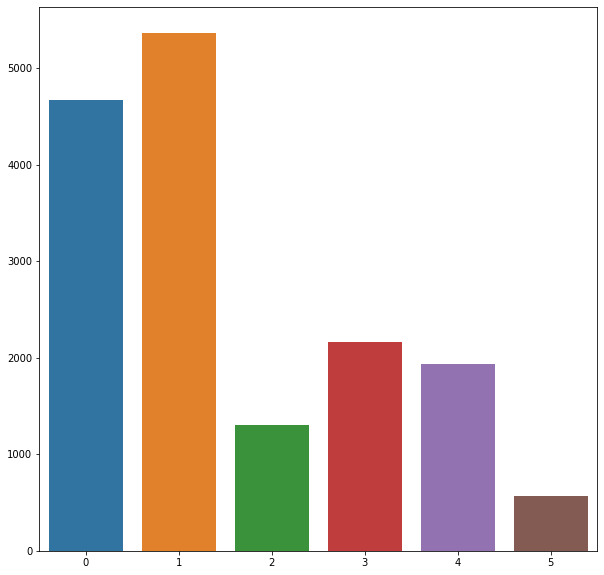

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
sns.barplot(x=data['label'].value_counts().index,y=data['label'].value_counts().values)
palette_color = sns.color_palette('bright')
  

  
# displaying chart
plt.show()

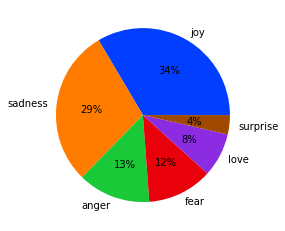

In [10]:
plt.pie(data['label'].value_counts(), labels=data['label'].apply(lambda x:emo_la[x]).value_counts().index, colors=palette_color, autopct='%.0f%%')
plt.show()

Imbalance data ratio between majority class and minority class > 4:1.
Which may affect precision and recall of the final model


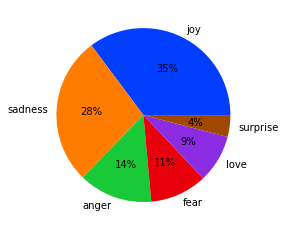

In [11]:
# validation and test data 
plt.pie(val_data['label'].value_counts(), labels=val_data['label'].apply(lambda x:emo_la[x]).value_counts().index, colors=palette_color, autopct='%.0f%%')
plt.show()

In [12]:
val_data['label'].value_counts()

1    704
0    550
3    275
4    212
2    178
5     81
Name: label, dtype: int64

# Data cleaning and preprocessing

Data augmentation was used to upsample the data, not by duplicating it, but by producing a sentence with a similar semantic meaning.

The nlp-aug library was used to perform data augmentation, which has various good functions .

In [ ]:
pip install nlpaug

**An algorithm was used that converts English to other languages and converts it back to English, so different text with the same semantic meaning of the sentence can be obtained.**

In [14]:
import nlpaug
import nlpaug.augmenter.word as naw

text = 'The quick brown fox jumped over the lazy dog'
back_translation_aug = naw.BackTranslationAug(
    from_model_name='facebook/wmt19-en-de', 
    to_model_name='facebook/wmt19-de-en'
)

Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/825 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.00G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/829k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/308k [00:00<?, ?B/s]

In [15]:
def new_sentance(s): 
    
    # initialize an empty string 
    string = " "
    
    # return string 
    return (string.join(back_translation_aug.augment(s))) 

In [16]:
text='i am now nearly finished the week detox and i feel amazing'


augmented_text = new_sentance(text)
print("Original:")
print(text)
print("Augmented Text:")
print(augmented_text)

Original:
i am now nearly finished the week detox and i feel amazing
Augmented Text:
I am now almost done with the week detox and I feel amazing


I have seen that 1:3 or 1:4 is the limit imbalanced class ration in some articles , although its not clear

**To address imbalanced data , i have added minority class data from validataion data to training data . I 've not added any test data 

**Although its not advisable to do add validation data as it may lead to data leakage.
I've not actually used  validation data  in training this model ****

In [17]:
data=pd.concat([data,val_data[val_data['label']==2]])

**There are several methods to address Imbalanced datasets, such as Upsampling, Downsampling, and Data augmentation.**

**Combination of all these methods may work better than each other alone So I have used all these methods**

In [18]:
pd.options.display.max_colwidth = 10
input_dataframe=data[data['label']==5].sort_values(by='text',ascending=True)[:200]

def add_data_to_dataframe(input_dataframe, func, output_dataframe):
    """Adds transformed data from input dataframe to output dataframe with label 5"""
    transformed_data = input_dataframe['text'].apply(func)
    new_data = pd.DataFrame({'text': transformed_data, 'label': 5})
    return pd.concat([output_dataframe, new_data], ignore_index=True)
   
data = add_data_to_dataframe(input_dataframe, new_sentance, data)

In [19]:
val_data['label'].value_counts()

1    704
0    550
3    275
4    212
2    178
5     81
Name: label, dtype: int64

In [20]:
data=pd.concat([data,val_data[val_data['label']==5]])

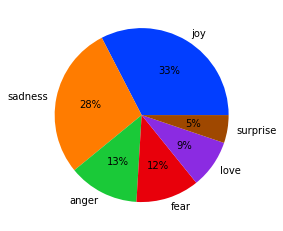

In [21]:
plt.pie(data['label'].value_counts(), labels=data['label'].apply(lambda x:emo_la[x]).value_counts().index, colors=palette_color, autopct='%.0f%%')
plt.show()

In [22]:
surprise_sentences = [
    "Wow, I can't believe I just won the lottery!",
    "You got married? That's a surprise!",
    "I was so surprised when I saw my old friend at the airport.",
    "What a surprise! I never thought I'd see a shooting star tonight.",
    "You're going to travel around the world? That's amazing!",
    "I was completely taken aback when I found out my sister was pregnant.",
    "I can't believe I just found my phone after thinking I lost it forever!",
    "That was a surprise twist in the movie, I never saw it coming.",
    "You're moving to a different country? That's a shock!",
    "I was pleasantly surprised when I tasted this new flavor of ice cream, it's delicious!",
    "I'm surprised that you actually remembered my birthday this year.",
    "What a surprise! The concert tickets are sold out already.",
    "I was shocked to see how much weight he had lost.",
    "I can't believe it! The restaurant is actually open on Christmas day.",
    "I was surprised when my boss gave me a promotion out of the blue.",
    "What a surprise! The book I wanted to buy is on sale.",
    "I was taken aback when I found out that my flight was canceled.",
    "I can't believe that you've never seen the ocean before!",
    "I was surprised when my grandmother told me she was learning how to use a computer.",
    "What a surprise! I never expected to see a peacock in the park.",
    "I was shocked to hear that my favorite band is breaking up.",
    "I can't believe that you're actually going bungee jumping.",
    "I was surprised when my nephew played the piano beautifully.",
    "What a surprise! I never thought I'd win the raffle.",
    "I was amazed when I saw the aurora borealis for the first time.",
    "I was shocked when I saw the amount of traffic on the highway.",
    "I can't believe that you've never tried sushi before!",
    "I was surprised when my coworker brought me coffee without me asking.",
    "What a surprise! The restaurant I wanted to go to just reopened.",
    "I was taken aback when I saw how much my friend had changed since high school.",
    "I can't believe that you've never been on a roller coaster before!",
    "I was surprised when my neighbor offered to help me with my groceries.",
    "What a surprise! The weather forecast was completely wrong.",
    "I was shocked when I heard that my favorite TV show was canceled.",
    "I can't believe that you've never been to a concert before!",
    "I was surprised when my sister told me she was going to law school.",
    "What a surprise! The package I ordered arrived two days early.",
    "I was taken aback when I found out that my coworker was secretly an artist.",
    "I can't believe that you've never gone camping before!",
    "I was surprised when my friend said she was going to run a marathon.",
    "What a surprise! I never expected to see a rainbow on such a cloudy day.",
    "I was amazed when I saw a double rainbow for the first time.",
    "I was shocked when I found out that my friend had never heard of Beyoncé.",
    "I can't believe that you've never seen a waterfall before!",
    "I was surprised when my coworker revealed that he was fluent in Mandarin.",
    "What a surprise! The museum I wanted to visit"]
new_data = pd.DataFrame({'text': surprise_sentences, 'label': 5})
data=pd.concat([data, new_data], ignore_index=True)


**And i have downsampled majority classes to reduce imbalanced data ratio**

In [23]:
import pandas as pd
from sklearn.utils import resample

# Separate the majority and minority classes
majority_class = data[data['label'] == 1]
# minority_class = data[data['label'] != 1]

# Downsample the majority class to get to the required label data ratio
majority_downsampled = resample(majority_class, 
                                replace=False,    # Sample without replacement
                                n_samples=4600,    # Size we want to reduce too
                                random_state=42)  # Set random state for reproducibility

# Combine the downsampled majority class with the minority class
downsampled_data = pd.concat([majority_downsampled, minority_class])

# Shuffle the combined dataset
data = downsampled_data.sample(frac=1).reset_index(drop=True)

# Print the class distribution of the downsampled dataset
print(data['label'].value_counts())

0    4666
1    4600
3    2159
4    1937
2    1482
5     899
Name: label, dtype: int64


In [24]:
import pandas as pd
from sklearn.utils import resample

# Separate the majority and minority classes
majority_class = data[data['label'] == 0]
minority_class = data[data['label'] != 0]

# Downsample the majority class to get to the required label data ratio
majority_downsampled = resample(majority_class, 
                                replace=False,    # Sample without replacement
                                n_samples=4400,    # Size we want to reduce too
                                random_state=42)  # Set random state for reproducibility

# Combine the downsampled majority class with the minority class
downsampled_data = pd.concat([majority_downsampled, minority_class])

# Shuffle the combined dataset
data = downsampled_data.sample(frac=1).reset_index(drop=True)

# Print the class distribution of the downsampled dataset
print(data['label'].value_counts())

1    4600
0    4400
3    2159
4    1937
2    1482
5     899
Name: label, dtype: int64


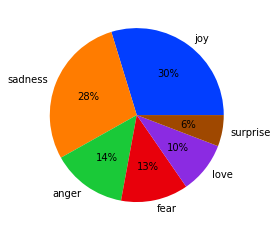

In [25]:
plt.pie(data['label'].value_counts(), labels=data['label'].apply(lambda x:emo_la[x]).value_counts().index, colors=palette_color, autopct='%.0f%%')
plt.show()

**Contractions and emojis would be replaced with valid text representation, and non-alphanumeric and symbols would be removed.**

**The word 'not' in stop words was not removed as I felt it would help the model to evaluate emotions better.**

In [12]:
import nltk
nltk.download('omw-1.4')
from nltk.stem import PorterStemmer
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim

import re
data_cl=data.copy()
contractions=pd.read_csv('../input/contractions/contractions.csv',index_col='Contraction')
contractions.index = contractions.index.str.lower()
contractions.Meaning = contractions.Meaning.str.lower()
contractions_dict = contractions.to_dict()['Meaning']
k=stopwords.words('english')

k=[i for i in k if i!='not']


[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


**A function was customized to apply various methods to clean the data**

In [13]:
urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|(www\.)[^ ]*)"
userPattern       = '@[^\s]+'
hashtagPattern    = '#[^\s]+'
alphaPattern      = "[^a-z0-9<>]"
sequencePattern   = r"(.)\1\1+"
seqReplacePattern = r"\1\1"

# Defining regex for emojis
smileemoji        = r"[8:=;]['`\-]?[)d]+"
sademoji          = r"[8:=;]['`\-]?\(+"
neutralemoji      = r"[8:=;]['`\-]?[\/|l*]"
lolemoji          = r"[8:=;]['`\-]?p+"
lemmatizer = WordNetLemmatizer()

def preprocess_apply(tweet):
    print(tweet)
    tweet = tweet.lower()

    # Replace all URls with '<url>'
    tweet = re.sub(urlPattern,'<url>',tweet)
    # Replace @USERNAME to '<user>'.
    tweet = re.sub(userPattern,'<user>', tweet)
    
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    # Replace all emojis.
    tweet = re.sub(r'<3', '<heart>', tweet)
    tweet = re.sub(smileemoji, '<smile>', tweet)
    tweet = re.sub(sademoji, '<sadface>', tweet)
    tweet = re.sub(neutralemoji, '<neutralface>', tweet)
    tweet = re.sub(lolemoji, '<lolface>', tweet)

    for contraction, replacement in contractions_dict.items():
        tweet = tweet.replace(contraction, replacement)

    # Remove non-alphanumeric and symbols
    tweet = re.sub(alphaPattern, ' ', tweet)

    # Adding space on either side of '/' to seperate words (After replacing URLS).
    tweet = re.sub(r'/', ' / ', tweet)
    tweet = nltk.word_tokenize(tweet)
    tweet = [lemmatizer.lemmatize(sentence)  for sentence in tweet if sentence not in k]
        #if sentence not in stopwords.words('english')
    return tweet

In [28]:
def text_cleaning(x):
    sentences=[]
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    for i in range(1):
        paragraph=x
        text = re.sub(r'\[[0-9]*\]',' ',paragraph)
        text =' '.join(word for word in text.split(' ') if not word.startswith('@'))
        text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
        sentenc = nltk.word_tokenize(text)
        #sentenc = sentenc.split()
        #print(sentenc)
        sentenc = [lemmatizer.lemmatize(sentence)  for sentence in sentenc if sentence not in stopwords.words('english')]
        #if sentence not in stopwords.words('english')
    return sentenc   

In [ ]:
pd.options.display.max_colwidth = 10
data_cl['text']=data['text'].apply(lambda x:preprocess_apply(x))
val_data['text']=val_data['text'].apply(lambda x:preprocess_apply(x))
test_data['text']=test_data['text'].apply(lambda x:preprocess_apply(x))


In [30]:
data['text'][50].lower()

'i just feel like i was foolish ignoring warnings about cell phones'

In [16]:
preprocess_apply("  i just feel like i was not foolish ignoring warnings about cell phones ")

  i just feel like i was not foolish ignoring warnings about cell phones 


['feel', 'like', 'not', 'foolish', 'ignoring', 'warning', 'cell', 'phone']

In [32]:
# for i in range(len(data_cl['text'])):
#     if any('servant' in z for z in X_test.loc[i]):
#         print(i,'yes')
#         break
    
# data_cl.loc[6,'text']

In [33]:
data_cl['text']=data_cl['text'].map(lambda x:' '.join(x))
val_data['text']=val_data['text'].map(lambda x:' '.join(x))
test_data['text']=test_data['text'].map(lambda x:' '.join(x))
data_cl.loc[6,'text']

'expect hope greater id feel disappointed'

**Tf-idf vectorizes based on word frequency**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
cv = TfidfVectorizer()
cv=TfidfVectorizer(max_features=3000).fit(data_cl['text'])
X = cv.fit_transform(data_cl['text']).toarray()
X.shape

In [ ]:
y=data_cl['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

**TFI DF model with random forest classifier**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier.fit(X_train, y_train)

In [ ]:
X_test=pd.read_csv('../input/emotion-dataset/validation.csv')
y_test=X_test['label']
X_test=X_test.drop(columns=['label'])
X_test['text']=X_test['text'].apply(lambda x:text_cleaning(x))
X_test['text']=X_test['text'].map(lambda x:' '.join(x))
X_test = cv.transform(X_test['text'])
X_test

In [ ]:
X_test

In [ ]:

y_pred = classifier.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
text='happy'
text=list(str(text).split("."))
text=pd.Series(text)
print(text)
text=text.apply(lambda x:preprocess_apply(x))
print(text)
text=text.apply(lambda x:' '.join(x))
print(text)
text = cv.transform(text)
emo_la[classifier.predict(text)[0]]
[emo_la[s] for s in classifier.predict(text)]

In [ ]:
import pickle
filename = 'finalized_model.pkl'
with open(filename,'wb') as f:
    pickle.dump(classifier,f)

In [ ]:
import pickle
filename = 'finalized_model_tfidf.pkl'
with open(filename,'wb') as f:
    pickle.dump(cv,f)

In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#tokenize and tag the card text
card_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(data_cl.text)]
#display the tagged docs
#card_docs

In [ ]:
#instantiate model
model = Doc2Vec(vector_size=24, window=2, min_count=1, workers=8, epochs = 100)
#build vocab
model.build_vocab(card_docs)
#train model
model.train(card_docs, total_examples=model.corpus_count
            , epochs=model.epochs)


In [ ]:
#generate vectors
card2vec = [model.infer_vector((data_cl.text[i].split(' '))) 
            for i in range(0,len(data_cl.text))]
#card2vec


In [ ]:
#Create a list of lists
dtv= np.array(card2vec).tolist()
#set list to dataframe column
data_cl['card2vec'] = dtv
data_cl.head(2)

In [ ]:
X=data_cl['card2vec']
y=data_cl['label']

In [ ]:
X=pd.DataFrame(item for item in X)
X

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier.fit(X, y)

In [ ]:
X_test=pd.read_csv('../input/emotion-dataset/validation.csv')
y_test=X_test['label']
X_test=X_test.drop(columns=['label'])
X_test['text']=X_test['text'].apply(lambda x:text_cleaning(x))
X_test['text']=X_test['text'].map(lambda x:' '.join(x))
card2vec = [model.infer_vector((X_test.text[i].split(' '))) 
            for i in range(0,len(X_test.text))]
#card2vec
#Create a list of lists
X_test= np.array(card2vec).tolist()
X_test=pd.DataFrame(item for item in X_test)
#set list to dataframe column
#X_test

In [ ]:
y_pred = classifier.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

#### Word2vec implemented with tfidf

In [ ]:
review_text = data['text'].apply(gensim.utils.simple_preprocess)

In [ ]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=1,
    workers=4,
)
model.build_vocab(review_text)

model.train(review_text, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
model.wv.most_similar('love')

In [ ]:

mod = Word2Vec(review_text, min_count=1)

words = model.wv.index_to_key



In [ ]:
lemmatizer = WordNetLemmatizer()
[lemmatizer.lemmatize(word ) for word in['give','take']]

In [ ]:
def sentence_to_vector(model,sentence):
    sentence=pd.Series(data=[sentence])
    sentence=sentence.apply(gensim.utils.simple_preprocess).tolist()
    sentence=[word for sen in sentence for word in sen]
    #print([model.wv.get_vector(word)  for word in sentence])
    return np.mean([model.wv.get_vector(word)  for word in sentence] ,axis=0)
    

In [ ]:
sentence=[[1,2],[2,0],[3,8],[4,6]]
np.mean([word  for word in sentence] ,axis=0)

In [ ]:
model.wv.get_vector('milligrams')

In [ ]:
# sentence=pd.Series(data=["i like cookies"])
# vec=sentence_to_vector(model,sentence)
# vec

In [ ]:
data_wv=data.copy()
data_wv['avg_vec']=data_wv['text'].apply(lambda x:sentence_to_vector(model,x))


In [ ]:
data_wv['label']

In [ ]:
X=data_wv['avg_vec']
y=data_wv['label']

In [ ]:
X=pd.DataFrame(item for item in X)
X

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score
# Fitting Random Forest Classification to the Training set
classifier = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', random_state = 42)
classifier.fit(X, y)

In [ ]:
X_test=pd.read_csv('../input/emotion-dataset/validation.csv')
y_test=X_test['label']
X_test=X_test.drop(columns=['label'])
X_test=X_test['text'].apply(gensim.utils.simple_preprocess)
documents=[]
for x in X_test:
    document = [word for word in x if word in model.wv.index_to_key]
    documents.append(document)
len(documents)

In [ ]:
counter = 0
for i in range (0,len(documents)):
    if documents[i] == []:
        counter += 1
print(counter)

In [ ]:
documents=[' '.join(i) for i in documents]
documents=pd.Series(data=documents)

In [ ]:
documents

In [ ]:
X_test=documents.apply(lambda x:sentence_to_vector(model,x))
X_test=pd.DataFrame(item for item in X_test)


In [ ]:
X_test

In [ ]:
y_pred = classifier.predict(X_test)
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
sent=['i am sad ']
sent=pd.DataFrame(data=sent,columns=['data'])
sent=sent['data'].apply(gensim.utils.simple_preprocess)
print(sent)
documents=[]
for x in sent:
    document = [word for word in x if word in model.wv.index_to_key]
    documents.append(document)
print(documents)
counter = 0
for i in range (0,len(documents)):
    if documents[i] == []:
        counter += 1
documents=[' '.join(i) for i in documents]
documents=pd.Series(data=documents)
sent=documents.apply(lambda x:sentence_to_vector(model,x))
sent=pd.DataFrame(item for item in sent)
sent

In [ ]:
emo_la[int(classifier.predict(sent))]

#### new_word2vec

In [ ]:
import re
def remove_tags(raw_text):
    cleaned_text = re.sub(re.compile('<.*?>'), '', raw_text)
    return cleaned_text

In [ ]:
df=data.copy()
df.drop_duplicates(inplace=True)

In [ ]:
df['text'] = df['text'].apply(lambda x:x.lower())

In [ ]:
from nltk.corpus import stopwords

sw_list = stopwords.words('english')

df['text'] = df['text'].apply(lambda x: [item for item in x.split() if item not in sw_list]).apply(lambda x:" ".join(x))

In [ ]:
import gensim
from nltk import sent_tokenize
from gensim.utils import simple_preprocess
story = []
for doc in df['text']:
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        story.append(simple_preprocess(sent))
    


In [ ]:
model = gensim.models.Word2Vec(
    window=10,
    min_count=1
)
model.build_vocab(story)
model.train(story, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)

In [ ]:
df.loc[8823]

In [ ]:
from tqdm import tqdm
X = []
for doc in tqdm(df['text'].values):
    X.append(document_vector(doc))

In [ ]:
X = np.array(X)
y=df['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
rf = RandomForestClassifier()
rf.fit(X_train,y_train)


In [ ]:
y_pred = rf.predict(X_test)
accuracy_score(y_test,y_pred)

**Bert Model**


In [ ]:
pip install transformers 

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=6)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [17]:
from sklearn.model_selection import train_test_split
X=data_cl['text']
y=data_cl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [18]:
train=pd.DataFrame()
test=pd.DataFrame()
train['text']=X_train
train['sentiment']=y_train
test['text']=X_test
test['sentiment']=y_test

In [ ]:
def convert_data_to_examples(train, test, text, sentiment): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[text], 
                                                          label = int(x[sentiment])), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[text], 
                                                          label = int(x[sentiment])), axis = 1,)
  
    return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train,  test, 'text',  'sentiment')

In [ ]:
from tqdm import tqdm
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,    # Add 'CLS' and 'SEP'
            max_length=max_length,    # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],input_dict["token_type_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'text'
LABEL_COLUMN = 'sentiment'

In [ ]:
import tensorflow as tf
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

In [ ]:
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

In [ ]:
num_labels = 6

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


model.fit(train_data, epochs=2,steps_per_epoch=115, validation_data=validation_data)

In [ ]:
train_data

In [ ]:
pred_sentences = [' dont know who lnocked the door ' , 'Wow, blew my mind, what a movie by Marvel, animation and story is amazing']
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model
tf_outputs = model(tf_batch)                                  
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       # axis=-1, this means that the index that will be returned by argmax will be taken from the *last* axis.
# labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", emo_la[label[i]])

In [ ]:
tf_predictions

In [ ]:
X_val
test_set=[i for i in X_val]

In [ ]:
def predict_bert(data):
    tf_batch = tokenizer(data, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model
    tf_outputs = model(tf_batch)                                  
    tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       # axis=-1, this means that the index that will be returned by argmax will be taken from the *last* axis.
    # labels = ['Negative','Positive']
    label = tf.argmax(tf_predictions, axis=1)
    y_pred = label.numpy()
    return y_pred

In [ ]:

from sklearn.metrics import confusion_matrix
y_pred=predict_bert(test_set)
confusion_matrix(y_val, y_pred)

In [ ]:
confusion_matrix(y_val, y_pred)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))
print(emo_la)

In [ ]:
model.save('bert_model')


In [ ]:
# model2 = tf.keras.models.clone_model(model)
# # Verify that the architecture is the same
# assert model1.summary() == model2.summary()

# # Verify that the weights are the same
# assert model1.get_weights() == model2.get_weights()

In [ ]:
!zip -r file.zip /kaggle/working/bert_model

Simple bert

In [51]:
# from transformers import BertTokenizer, TFBertForSequenceClassification
# from transformers import InputExample, InputFeatures

# model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=6)
# tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [15]:
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [126]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=6)

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_77', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [26]:
from sklearn.model_selection import train_test_split
X=data_cl['text']
y=data_cl['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [27]:
train=pd.DataFrame()
test=pd.DataFrame()
train['text']=X_train
train['sentiment']=y_train
test['text']=X_test
test['sentiment']=y_test

In [19]:
from transformers import InputExample, InputFeatures

In [20]:
def convert_data_to_examples(train, test, text, sentiment): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[text], 
                                                          label = int(x[sentiment])), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[text], 
                                                          label = int(x[sentiment])), axis = 1,)
  
    return train_InputExamples, validation_InputExamples

train_InputExamples, validation_InputExamples = convert_data_to_examples(train,  test, 'text',  'sentiment')

In [21]:
from tqdm import tqdm
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in tqdm(examples):
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,    # Add 'CLS' and 'SEP'
            max_length=max_length,    # truncates if len(s) > max_length
#             return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])
        features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask,  label=e.label) )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
#                     "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
#                 "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'text'
LABEL_COLUMN = 'sentiment'

In [22]:
import tensorflow as tf
train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

  0%|          | 0/9600 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
100%|██████████| 9600/9600 [00:05<00:00, 1873.02it/s]


In [23]:
validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

100%|██████████| 3200/3200 [00:01<00:00, 1860.23it/s]


In [24]:
pip install tensorflow_model_optimization 


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 6.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [25]:
import tensorflow_model_optimization 
from tensorflow_model_optimization.sparsity import keras as sparsity
# Define the pruning schedule
pruning_schedule = sparsity.PolynomialDecay(initial_sparsity=0.85,
                                             final_sparsity=0.90,
                                             begin_step=2000,
                                             end_step=4000)

# Create a pruning callback that will apply pruning to the model
pruning_callbacks = [sparsity.UpdatePruningStep()]

In [26]:
# import tensorflow_model_optimization as tfmot

# config = tfmot.quantization.keras.QuantizeConfig()
# # Annotate the model with quantization
# config.set_quantize_aware_activation(tfmot.quantization.keras.quantizers.LastValueQuantizer(num_bits=8, symmetric=True, narrow_range=True))
# config.set_quantize_provider(lambda layer: "quantize_aware")

# quantisation not working with bert models right now  ot i'm not aware if its working

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


model.fit(train_data, epochs=1,steps_per_epoch=11, validation_data=validation_data,callbacks=pruning_callbacks)

11/11 [==============================] - 571s 54s/step - loss: 1.7377 - accuracy: 0.2528 - val_loss: 1.6189 - val_accuracy: 0.3541


In [106]:
pred_sentences = [' interview tomorrow,dont know if iam prepared ' , 'Wow, blew my mind, what a movie by Marvel, animation and story is amazing']
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')   # we are tokenizing before sending into our trained model
tf_outputs = sequential_model(tf_batch)                                  
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)       # axis=-1, this means that the index that will be returned by argmax will be taken from the *last* axis.
# labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": ", emo_la[label[i]])

 interview tomorrow,dont know if iam prepared  :  joy


In [124]:
def predict_bert(data):
    tf_batch = tokenizer(data, max_length=128, padding=True, truncation=True, return_tensors='tf')
    tf_outputs = model(tf_batch)                                  
    tf_predictions = tf.nn.softmax(tf_outputs.logits, axis=-1)
    label = tf.argmax(tf_predictions, axis=1)
    y_pred = label.numpy()
    return y_pred

In [30]:
X_val
test_set=[i for i in X_val]

In [125]:
from sklearn.metrics import confusion_matrix
y_pred=predict_bert(test_set[:50])
confusion_matrix(y_val[:50], y_pred)

AttributeError: 'TFBaseModelOutput' object has no attribute 'dtype'

In [121]:
# model = tf.keras.Sequential([
#     model.layers[0],  # Add the DistilBert layer
#     model.layers[1],  # Add the pre-classifier dense layer
#     model.layers[2],  # Add the classifier dense layer
#     model.layers[3]   # Add the dropout layer
# ])

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))
print(emo_la)

              precision    recall  f1-score   support

           0       0.40      0.03      0.05       959
           1       0.33      0.99      0.49      1044
           2       0.00      0.00      0.00       249
           3       0.00      0.00      0.00       440
           4       0.00      0.00      0.00       406
           5       0.00      0.00      0.00       102

    accuracy                           0.33      3200
   macro avg       0.12      0.17      0.09      3200
weighted avg       0.23      0.33      0.18      3200

0.3303125
{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
model.summary()


Model: "tf_distil_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
distilbert (TFDistilBertMain multiple                  66362880  
_________________________________________________________________
pre_classifier (Dense)       multiple                  590592    
_________________________________________________________________
classifier (Dense)           multiple                  4614      
_________________________________________________________________
dropout_19 (Dropout)         multiple                  0         
Total params: 66,958,086
Trainable params: 66,958,086
Non-trainable params: 0
_________________________________________________________________


In [34]:
# bert_model = tf.keras.Sequential([
#     model.distilbert,
#     model.pre_classifier,
#     model.classifier,
#     model.dropout,
# ])


# # Compile the Sequential model
# input_shape = tf.shape(X_train)
# input_shape_int = tf.cast(input_shape, tf.int32)
# input_data = tf.constant([[1, 2], [3, 4], [5, 6]], dtype=tf.int32)
# bert_model(input_data)


AttributeError: 'TFBaseModelOutput' object has no attribute 'dtype'

In [35]:
# sequential_model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name='input_ids'),
#     model.distilbert,
#     model.pre_classifier,
#     model.classifier,
#     model.dropout
# ])

# # Set the weights of the sequential model to the pre-trained model's weights
# sequential_model.set_weights(model.get_weights())

# # Compile the model


In [ ]:
train_labels

In [ ]:
tokens = tokenizer(list(X_train), padding=True, truncation=True, max_length=128, return_tensors='tf')
from tensorflow.keras.utils import to_categorical
# Convert label data to tensor
train_labels = tf.convert_to_tensor(list(y_train))
train_labels = to_categorical(train_labels, num_classes=6)

# Create a TensorFlow Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((dict(tokens), train_labels)).batch(32)
tokens = tokenizer(list(X_test), padding=True, truncation=True, max_length=128, return_tensors='tf')

# Convert label data to tensor
val_labels = tf.convert_to_tensor(list(y_test))
val_labels = to_categorical(val_labels, num_classes=6)

# Create a TensorFlow Dataset
val_dataset = tf.data.Dataset.from_tensor_slices((dict(tokens), val_labels)).batch(32)





In [ ]:
train_dataset

In [ ]:
# sequential_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])


# sequential_model.fit(train_dataset, epochs=2,steps_per_epoch=115, validation_data=val_dataset,callbacks=pruning_callbacks)

In [ ]:
# load the weights from the original model into the new model
bert_model.set_weights(model.get_weights())

In [ ]:
tf.saved_model.save(model, "pruned_model")

# Convert the pruned model to TFLite format
converter = tf.lite.TFLiteConverter.from_saved_model("pruned_model")
tflite_model = converter.convert()

# Save the TFLite model in a compressed format
with open("pruned_model.tflite", "wb") as f:
    f.write(tflite_model)

In [42]:
sequential_model.save('my_model.h5')

In [180]:
import os

# set the path to the saved model file
model_path = "/kaggle/working/my_model.h5"

# get the size of the file in bytes
size_bytes = os.path.getsize(model_path)

# convert to megabytes (MB)
size_mb = size_bytes / (1024 * 1024)

# convert to gigabytes (GB)
size_gb = size_mb / 1024

print("Model size: {:.2f} MB ({:.2f} GB)".format(size_mb, size_gb))

Model size: 766.67 MB (0.75 GB)


different bert model with sequential


In [182]:
# sequential_model = tf.keras.Sequential([
#     model
# ])

In [170]:
# def create_model():
#     distilbert = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
#     input_ids = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="input_ids")
#     attention_mask = tf.keras.layers.Input(shape=(128,), dtype=tf.int32, name="attention_mask")

#     sequence_output = distilbert(input_ids)[0]

#     # Add a dense layer for classification
#     flatten = tf.keras.layers.Flatten()(sequence_output)
#     dense = tf.keras.layers.Dense(6, activation='softmax')(flatten)

#     model = tf.keras.models.Model(inputs=[input_ids, attention_mask], outputs=dense)
#     return model
# # Create the model
# func_model = create_model()

# # Compile the model


# # Train the model...



Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'vocab_transform', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
# func_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])
# func_model.fit(train_data, epochs=2,steps_per_epoch=115, validation_data=validation_data,callbacks=pruning_callbacks)

In [ ]:
# quantize_model = tfmot.quantization.keras.quantize_model

# # q_aware stands for for quantization aware.
# q_aware_model = quantize_model(func_model)

In [184]:
# sequential_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
#               metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [185]:
# sequential_model.fit(train_data, epochs=1,steps_per_epoch=1, validation_data=validation_data,callbacks=pruning_callbacks)

1/1 [==============================] - 480s 480s/step - loss: 1.5311 - accuracy: 0.3750 - val_loss: 1.5906 - val_accuracy: 0.3466


In [134]:
# def predict_bert(data):
#     tf_batch = tokenizer(data, max_length=128, padding=True, truncation=True, return_tensors='tf')
#     tf_outputs = sequential_model(tf_batch)                                  
#     tf_predictions = tf.nn.softmax(tf_outputs.logits, axis=-1)
#     label = tf.argmax(tf_predictions, axis=1)
#     y_pred = label.numpy()
#     return y_pred

In [135]:
# from sklearn.metrics import confusion_matrix
# y_pred=predict_bert(test_set[:50])
# confusion_matrix(y_val[:50], y_pred)

array([[ 0, 15,  0,  0,  0],
       [ 0, 21,  0,  0,  0],
       [ 0,  4,  0,  0,  0],
       [ 0,  3,  0,  0,  0],
       [ 0,  7,  0,  0,  0]])

In [173]:

# # Convert the quantized model to TFLite
# converter = tf.lite.TFLiteConverter.from_keras_model(quantized_model)

# # Enable TF Select
# converter.experimental_new_converter=True
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
#                                        tf.lite.OpsSet.SELECT_TF]

# tflite_model = converter.convert()

NameError: name 'quantized_model' is not defined

In [181]:
# sequential_model.save('my_model.h5')

ValueError: Weights for model sequential_5 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

bert model torch 

In [18]:
 
pip install --pre torch -f 



Usage:   
  /opt/conda/bin/python -m pip install [options] <requirement specifier> [package-index-options] ...
  /opt/conda/bin/python -m pip install [options] -r <requirements file> [package-index-options] ...
  /opt/conda/bin/python -m pip install [options] [-e] <vcs project url> ...
  /opt/conda/bin/python -m pip install [options] [-e] <local project path> ...
  /opt/conda/bin/python -m pip install [options] <archive url/path> ...

-f option requires 1 argument
Note: you may need to restart the kernel to use updated packages.


In [19]:
# import torch

# # If there's a GPU available...
# if torch.cuda.is_available():    

#     # Tell PyTorch to use the GPU.    
#     device = torch.device("cuda")

#     print('There are %d GPU(s) available.' % torch.cuda.device_count())

#     print('We will use the GPU:', torch.cuda.get_device_name(0))

# # If not...
# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

In [20]:
from __future__ import absolute_import, division, print_function

import logging
import numpy as np
import os
import random
import sys
import time
import torch

from argparse import Namespace
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from tqdm import tqdm
from transformers import (BertConfig, BertForSequenceClassification, BertTokenizer,)
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors
from transformers import glue_convert_examples_to_features as convert_examples_to_features

# Setup logging
logger = logging.getLogger(__name__)
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.WARN)

logging.getLogger("transformers.modeling_utils").setLevel(
   logging.WARN)  # Reduce logging

print(torch.__version__)

1.11.0+cpu


In [21]:
configs = Namespace()

# The output directory for the fine-tuned model, $OUT_DIR.
configs.output_dir = "./MRPC/"

# The data directory for the MRPC task in the GLUE benchmark, $GLUE_DIR/$TASK_NAME.
configs.data_dir = "./glue_data/MRPC"

# The model name or path for the pre-trained model.
configs.model_name_or_path = "bert-base-uncased"
# The maximum length of an input sequence
configs.max_seq_length = 128

# Prepare GLUE task.
configs.task_name = "MRPC".lower()
configs.processor = processors[configs.task_name]()
configs.output_mode = output_modes[configs.task_name]
configs.label_list = configs.processor.get_labels()
configs.model_type = "bert".lower()
configs.do_lower_case = True

# Set the device, batch size, topology, and caching flags.
configs.device = "cpu"
configs.per_gpu_eval_batch_size = 8
configs.n_gpu = 0
configs.local_rank = -1
configs.overwrite_cache = False

/opt/conda/lib/python3.7/site-packages/transformers/data/processors/glue.py:174: FutureWarning: This processor will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("processor"), FutureWarning)


In [22]:
# Set random seed for reproducibility.
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(42)

In [23]:
# tokenizer = BertTokenizer.from_pretrained(
#     configs.output_dir, do_lower_case=configs.do_lower_case)

# model = BertForSequenceClassification.from_pretrained(configs.output_dir)


In [24]:
from transformers import BertTokenizer, BertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=6,return_dict=False)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [25]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors and The HuggingFace Inc. team.
# Copyright (c) 2018, NVIDIA CORPORATION.  All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

def evaluate(args, model, tokenizer, prefix=""):
    # Loop to handle MNLI double evaluation (matched, mis-matched)
    eval_task_names = ("mnli", "mnli-mm") if args.task_name == "mnli" else (args.task_name,)
    eval_outputs_dirs = (args.output_dir, args.output_dir + '-MM') if args.task_name == "mnli" else (args.output_dir,)

    results = {}
    for eval_task, eval_output_dir in zip(eval_task_names, eval_outputs_dirs):
        eval_dataset = load_and_cache_examples(args, eval_task, tokenizer, evaluate=True)

        if not os.path.exists(eval_output_dir) and args.local_rank in [-1, 0]:
            os.makedirs(eval_output_dir)

        args.eval_batch_size = args.per_gpu_eval_batch_size * max(1, args.n_gpu)
        # Note that DistributedSampler samples randomly
        eval_sampler = SequentialSampler(eval_dataset) if args.local_rank == -1 else DistributedSampler(eval_dataset)
        eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

        # multi-gpu eval
        if args.n_gpu > 1:
            model = torch.nn.DataParallel(model)

        # Eval!
        logger.info("***** Running evaluation {} *****".format(prefix))
        logger.info("  Num examples = %d", len(eval_dataset))
        logger.info("  Batch size = %d", args.eval_batch_size)
        eval_loss = 0.0
        nb_eval_steps = 0
        preds = None
        out_label_ids = None
        for batch in tqdm(eval_dataloader, desc="Evaluating"):
            model.eval()
            batch = tuple(t.to(args.device) for t in batch)

            with torch.no_grad():
                inputs = {'input_ids':      batch[0],
                          'attention_mask': batch[1],
                          'labels':         batch[3]}
                if args.model_type != 'distilbert':
                    inputs['token_type_ids'] = batch[2] if args.model_type in ['bert', 'xlnet'] else None  # XLM, DistilBERT and RoBERTa don't use segment_ids
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]

                eval_loss += tmp_eval_loss.mean().item()
            nb_eval_steps += 1
            if preds is None:
                preds = logits.detach().cpu().numpy()
                out_label_ids = inputs['labels'].detach().cpu().numpy()
            else:
                preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
                out_label_ids = np.append(out_label_ids, inputs['labels'].detach().cpu().numpy(), axis=0)

        eval_loss = eval_loss / nb_eval_steps
        if args.output_mode == "classification":
            preds = np.argmax(preds, axis=1)
        elif args.output_mode == "regression":
            preds = np.squeeze(preds)
        result = compute_metrics(eval_task, preds, out_label_ids)
        results.update(result)

        output_eval_file = os.path.join(eval_output_dir, prefix, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results {} *****".format(prefix))
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

    return results


def load_and_cache_examples(args, task, tokenizer, evaluate=False):
    if args.local_rank not in [-1, 0] and not evaluate:
        torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

    processor = processors[task]()
    output_mode = output_modes[task]
    # Load data features from cache or dataset file
    cached_features_file = os.path.join(args.data_dir, 'cached_{}_{}_{}_{}'.format(
        'dev' if evaluate else 'train',
        list(filter(None, args.model_name_or_path.split('/'))).pop(),
        str(args.max_seq_length),
        str(task)))
    if os.path.exists(cached_features_file) and not args.overwrite_cache:
        logger.info("Loading features from cached file %s", cached_features_file)
        features = torch.load(cached_features_file)
    else:
        logger.info("Creating features from dataset file at %s", args.data_dir)
        label_list = processor.get_labels()
        if task in ['mnli', 'mnli-mm'] and args.model_type in ['roberta']:
            # HACK(label indices are swapped in RoBERTa pretrained model)
            label_list[1], label_list[2] = label_list[2], label_list[1]
        examples = processor.get_dev_examples(args.data_dir) if evaluate else processor.get_train_examples(args.data_dir)
        features = convert_examples_to_features(examples,
                                                tokenizer,
                                                label_list=label_list,
                                                max_length=args.max_seq_length,
                                                output_mode=output_mode,
                                                pad_on_left=bool(args.model_type in ['xlnet']),                 # pad on the left for xlnet
                                                pad_token=tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0],
                                                pad_token_segment_id=4 if args.model_type in ['xlnet'] else 0,
        )
        if args.local_rank in [-1, 0]:
            logger.info("Saving features into cached file %s", cached_features_file)
            torch.save(features, cached_features_file)

    if args.local_rank == 0 and not evaluate:
        torch.distributed.barrier()  # Make sure only the first process in distributed training process the dataset, and the others will use the cache

    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_labels = torch.tensor([f.label for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset

In [26]:
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
# print(quantized_model)

In [27]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)
print_size_of_model(quantized_model)

Size (MB): 438.029613
Size (MB): 181.500229


In [27]:
X_train=data_cl['text']
y_train=data_cl['label']
X_train=data_cl['text']
y_train=data_cl['label']
X_val=val_data['text']
y_val=val_data['label']
X_test=test_data['text']
y_test=test_data['label']

In [29]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_train:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(np.array(y_train))

# Print sentence 0, now as a list of IDs.
print('Original: ', X_train[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  didnt feel humiliated
Token IDs: tensor([  101,  2134,  2102,  2514, 26608,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

In [30]:
train_dataset = TensorDataset(input_ids, attention_masks, labels)

In [31]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in X_val:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(np.array(y_val))

# Print sentence 0, now as a list of IDs.
print('Original: ', X_train[0])
print('Token IDs:', input_ids[0])

Original:  didnt feel humiliated
Token IDs: tensor([  101, 10047,  3110,  3243,  6517,  3374,  5665, 10245,  2574,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0

In [32]:
val_dataset = TensorDataset(input_ids, attention_masks, labels)

In [33]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [55]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(quantized_model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [56]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


In [36]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [37]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [38]:
# import tensorflow as tf

# # Get the GPU device name.
# device_name = tf.test.gpu_device_name()

# # The device name should look like the following:
# if device_name == '/device:GPU:0':
#     print('Found GPU at: {}'.format(device_name))
# else:
#     raise SystemError('GPU device not found')

In [39]:
# import torch

# # If there's a GPU available...
# if torch.cuda.is_available():    

#     # Tell PyTorch to use the GPU.    
#     device = torch.device("cuda")

#     print('There are %d GPU(s) available.' % torch.cuda.device_count())

#     print('We will use the GPU:', torch.cuda.get_device_name(0))

# # If not...
# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")

In [40]:
# device = torch.device("cuda")
# quantized_model.cuda()

In [58]:
import random
import numpy as np
from torch.autograd import Variable


# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    quantized_model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        quantized_model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = quantized_model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()
        loss = Variable(loss, requires_grad = True)

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(quantized_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            #  
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            loss, logits = quantized_model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


KeyboardInterrupt: 

In [ ]:
def finetune(epochs,dataloader,model,loss_fn,optimizer):
    model.train()
    for  epoch in range(epochs):
        print(epoch)
        
        loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
        for batch, dl in loop:
            ids=dl['ids']
            token_type_ids=dl['token_type_ids']
            mask= dl['mask']
            label=dl['target']
            label = label.unsqueeze(1)
            
            optimizer.zero_grad()
            
            output=model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids)
            label = label.type_as(output)

            loss=loss_fn(output,label)
            loss.backward()
            
            optimizer.step()
            
            pred = np.where(output >= 0, 1, 0)

            num_correct = sum(1 for a, b in zip(pred, label) if a[0] == b[0])
            num_samples = pred.shape[0]
            accuracy = num_correct/num_samples
            
            print(f'Got {num_correct} / {num_samples} with accuracy {float(num_correct)/float(num_samples)*100:.2f}')
            
            # Show progress while training
            loop.set_description(f'Epoch={epoch}/{epochs}')
            loop.set_postfix(loss=loss.item(),acc=accuracy)

    return model

In [42]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.95,1.96,0.04,0:57:29,0:05:13
2,1.94,1.96,0.04,0:57:01,0:05:13


In [43]:
import pandas as pd

# Load the dataset into a pandas dataframe.


# Create sentence and label lists
sentences = X_test
labels = np.array(y_test)

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


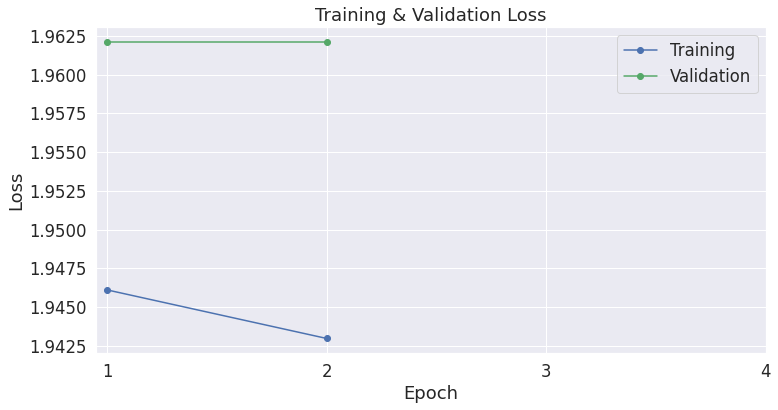

In [59]:
import matplotlib.pyplot as plt
# % matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [49]:
y_val.value_counts()

1    704
0    550
3    275
4    212
2    178
5     81
Name: label, dtype: int64

Pytorch bert quantized

In [25]:
from transformers import DistilBertTokenizer, DistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained("distilbert-base-uncased",num_labels=6)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
import torch
encoded_data_train = tokenizer.batch_encode_plus(
    X_train,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=64,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
    X_val,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=64,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(np.array(y_train))

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(np.array(y_val))

In [35]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val,
                           labels_val)

In [32]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

In [34]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
batch_size = 32

dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

NameError: name 'dataset_train' is not defined

In [36]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [37]:
optimizer = AdamW(
    quantized_model.parameters(),
    lr = 1e-5,
    eps = 1e-8
)

NameError: name 'quantized_model' is not defined

In [66]:
epochs = 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps = len(dataloader_train)*epochs
)

In [67]:
import numpy as np
from sklearn.metrics import f1_score

In [68]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [69]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [70]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [72]:
def evaluate(dataloader_val):

    quantized_model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = quantized_model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        print(loss_val_total)

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val)
    print('loss_val_avg':loss_val_avg)
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [94]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
   
    
    for batch in progress_bar:
        model.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids': batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        
        outputs = model(**inputs)
        loss = outputs[0]
        loss_train_total +=loss.item()
        loss = Variable(loss, requires_grad = True)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    #torch.save(model.state_dict(), f'Models/BERT_ft_Epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]          


TypeError: forward() got an unexpected keyword argument 'labels'

In [87]:
input_ids_train[0]

tensor([  101,  2134,  2102,  2514, 26608,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])

In [65]:
quantized_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.Linear}, dtype=torch.qint8
)
print(quantized_model)

NotImplementedError: Could not run 'quantized::linear_prepack' with arguments from the 'QuantizedCUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear_prepack' is only available for these backends: [QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, Tracer, AutocastCPU, Autocast, Batched, VmapMode, Functionalize].

QuantizedCPU: registered at /usr/local/src/pytorch/aten/src/ATen/native/quantized/cpu/qlinear_prepack.cpp:324 [kernel]
BackendSelect: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /usr/local/src/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at /usr/local/src/pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /usr/local/src/pytorch/aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at /usr/local/src/pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /usr/local/src/pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:35 [backend fallback]
AutogradCPU: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:39 [backend fallback]
AutogradCUDA: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:47 [backend fallback]
AutogradXLA: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:51 [backend fallback]
AutogradLazy: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:55 [backend fallback]
AutogradXPU: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:43 [backend fallback]
AutogradMLC: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:59 [backend fallback]
AutogradHPU: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:68 [backend fallback]
Tracer: registered at /usr/local/src/pytorch/torch/csrc/autograd/TraceTypeManual.cpp:293 [backend fallback]
AutocastCPU: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/autocast_mode.cpp:461 [backend fallback]
Autocast: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/autocast_mode.cpp:305 [backend fallback]
Batched: registered at /usr/local/src/pytorch/aten/src/ATen/BatchingRegistrations.cpp:1059 [backend fallback]
VmapMode: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at /usr/local/src/pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:52 [backend fallback]


In [39]:
import torch
from torch.utils.data import DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup


# Define hyperparameters
batch_size = 32
epochs = 3
lr = 2e-5
eps = 1e-8
max_grad_norm = 1.0
num_classes = 6
quantization_bits = 8

In [40]:
dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

In [41]:
# Load BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()


Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
# Train model
for epoch in range(epochs):
    model.train()
    for step, batch in enumerate(dataloader_train):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        print(f'loss :{loss}')
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
   

In [63]:
def multi_label_accuracy(logits, labels):
    """Calculates accuracy for multi-label classification"""
    with torch.no_grad():
        predictions = torch.sigmoid(logits) > 0.5
        correct_predictions = (predictions.cuda() == labels.byte())
        accuracy = correct_predictions.float().mean()
    return accuracy


In [ ]:
 # Evaluate on validation set
model.eval()
total_val_loss, total_val_accuracy = 0, 0
with torch.no_grad():
    for batch in dataloader_val:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            print(labels)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            logits = outputs[1]
            logits = torch.argmax(logits, dim=1)
            tensor= logits.cpu()
            logits = tensor
            print(logits)
            total_val_loss += loss.item()
            total_val_accuracy += multi_label_accuracy(logits, labels)
    avg_val_loss = total_val_loss / len(dataloader_val)
    avg_val_accuracy = total_val_accuracy / len(dataloader_val)
    print(f'Epoch {epoch + 1} - Val Loss: {avg_val_loss:.4f} - Val Accuracy: {avg_val_accuracy:.4f}')
    

In [72]:
from torch.quantization import quantize_static


qconfig_dict = {'': torch.quantization.default_qconfig}
quantized_model = quantize_static(model, qconfig_dict, dtype=torch.qint8)

ImportError: cannot import name 'quantize_static' from 'torch.quantization' (/opt/conda/lib/python3.7/site-packages/torch/quantization/__init__.py)

In [71]:
!add-apt-repository -y ppa:deadsnakes/ppa
!apt install -y python3

Get:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease [5002 B]
Get:2 https://packages.cloud.google.com/apt cloud-sdk InRelease [6361 B]       
Get:3 https://packages.cloud.google.com/apt google-fast-socket InRelease [5015 B]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease [1581 B]
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]      
Err:1 http://packages.cloud.google.com/apt gcsfuse-focal InRelease             
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY B53DC80D13EDEF05
Get:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease [18.1 kB] 
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease    
Err:2 https://packages.cloud.google.com/apt cloud-sdk InRelease
  The following signatures couldn't be verified because the public key is not available: NO_PUBKEY B53DC80D13EDEF05
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [11

In [ ]:
quant_model = torch.quantization.quantize_dynamic(
    model, {torch.nn.GaussianNLLLoss}, dtype=torch.qint8
)
quant_model.eval()


In [79]:
# Evaluate on validation set
quant_model.eval()
total_val_loss, total_val_accuracy = 0, 0
with torch.no_grad():
    for batch in dataloader_val:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = quant_model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            logits = outputs[1]
            logits = torch.argmax(logits, dim=1)
            tensor= logits.cpu()
            logits = tensor
            
            total_val_loss += loss.item()
            total_val_accuracy += multi_label_accuracy(logits, labels)
    avg_val_loss = total_val_loss / len(dataloader_val)
    avg_val_accuracy = total_val_accuracy / len(dataloader_val)
    print(f'Epoch {epoch + 1} - Val Loss: {avg_val_loss:.4f} - Val Accuracy: {avg_val_accuracy:.4f}')
    

Epoch 3 - Val Loss: 0.1481 - Val Accuracy: 0.6151


In [98]:
from __future__ import absolute_import, division, print_function

import logging
import numpy as np
import os
import random
import sys
import time
import torch

from argparse import Namespace
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from tqdm import tqdm
from transformers import (BertConfig, BertForSequenceClassification, BertTokenizer,)
from transformers import glue_compute_metrics as compute_metrics
from transformers import glue_output_modes as output_modes
from transformers import glue_processors as processors
from transformers import glue_convert_examples_to_features as convert_examples_to_features

# Setup logging
logger = logging.getLogger(__name__)
logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.WARN)

logging.getLogger("transformers.modeling_utils").setLevel(
   logging.WARN)  # Reduce logging

print(torch.__version__)
configs = Namespace()

configs.device = "cpu"
configs.per_gpu_eval_batch_size = 8
configs.n_gpu = 0
configs.local_rank = -1
configs.overwrite_cache = False
quantized_model = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

1.11.0


NotImplementedError: Could not run 'quantized::linear_prepack' with arguments from the 'QuantizedCUDA' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear_prepack' is only available for these backends: [QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, Tracer, AutocastCPU, Autocast, Batched, VmapMode, Functionalize].

QuantizedCPU: registered at /usr/local/src/pytorch/aten/src/ATen/native/quantized/cpu/qlinear_prepack.cpp:324 [kernel]
BackendSelect: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /usr/local/src/pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at /usr/local/src/pytorch/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /usr/local/src/pytorch/aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at /usr/local/src/pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /usr/local/src/pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:35 [backend fallback]
AutogradCPU: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:39 [backend fallback]
AutogradCUDA: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:47 [backend fallback]
AutogradXLA: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:51 [backend fallback]
AutogradLazy: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:55 [backend fallback]
AutogradXPU: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:43 [backend fallback]
AutogradMLC: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:59 [backend fallback]
AutogradHPU: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/core/VariableFallbackKernel.cpp:68 [backend fallback]
Tracer: registered at /usr/local/src/pytorch/torch/csrc/autograd/TraceTypeManual.cpp:293 [backend fallback]
AutocastCPU: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/autocast_mode.cpp:461 [backend fallback]
Autocast: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/autocast_mode.cpp:305 [backend fallback]
Batched: registered at /usr/local/src/pytorch/aten/src/ATen/BatchingRegistrations.cpp:1059 [backend fallback]
VmapMode: fallthrough registered at /usr/local/src/pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at /usr/local/src/pytorch/aten/src/ATen/FunctionalizeFallbackKernel.cpp:52 [backend fallback]


In [95]:

import torch.quantization as quantization
# define the quantization configuration
torch.backends.quantized.engine = 'fbgemm'

# Quantize the model
quantized_model = quantization.quantize_dynamic(model, config_dict)

/opt/conda/lib/python3.7/site-packages/torch/ao/quantization/observer.py:179: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  - ``torch.per_channel_symmetric``


AssertionError: Embedding quantization is only supported with float_qparams_weight_only_qconfig.

In [89]:
import torch
from torch.quantization import per_channel_dynamic_qconfig
from torch.quantization import quantize_dynamic_jit

ts_model = torch.jit.script(model) # or torch.jit.trace(float_model, input)

quantized = quantize_dynamic_jit(ts_model, {'': per_channel_dynamic_qconfig})

UnsupportedNodeError: GeneratorExp aren't supported:
  File "/opt/conda/lib/python3.7/site-packages/transformers/modeling_utils.py", line 1538
        activations".
        """
        return any(hasattr(m, "gradient_checkpointing") and m.gradient_checkpointing for m in self.modules())
                   ~ <--- HERE


In [87]:
qconfig_dict = {'': per_channel_dynamic_qconfig}

NameError: name 'per_channel_dynamic_qconfig' is not defined

In [99]:
from transformers import DistilBertTokenizer, TFDistilBertModel
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = TFDistilBertModel.from_pretrained("distilbert-base-uncased")

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_layer_norm', 'activation_13', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [34]:
import torch
from torch.utils.data import DataLoader
from transformers import  AdamW

In [35]:
# Define hyperparameters
batch_size = 32
epochs = 10
lr = 2e-5
eps = 1e-8
max_grad_norm = 1.0
num_classes = 6
quantization_bits = 8

In [36]:
X_train=data_cl['text']
y_train=data_cl['label']
X_train=data_cl['text']
y_train=data_cl['label']
X_val=val_data['text']
y_val=val_data['label']
X_test=test_data['text']
y_test=test_data['label']

In [37]:
import torch
import transformers
from transformers import AutoTokenizer, MobileBertForSequenceClassification,DistilBertTokenizer

model_name = r'cambridgeltl/sst_mobilebert-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
config = transformers.MobileBertConfig(vocab_size = len(tokenizer.get_vocab()))
config.num_labels = 6
id2label = {}
# for i in range(config.num_labels):
#     id2label[i] = data_cl["label"].int2str(i)
id2label=emo_la



Downloading:   0%|          | 0.00/268 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [38]:
config.id2label = id2label
config.label2id = {v:k for k,v in id2label.items()}

model = MobileBertForSequenceClassification.from_pretrained(model_name, config=config,ignore_mismatched_sizes=True)

Downloading:   0%|          | 0.00/94.2M [00:00<?, ?B/s]

Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at cambridgeltl/sst_mobilebert-uncased and are newly initialized: ['mobilebert.pooler.dense.weight', 'mobilebert.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MobileBertForSequenceClassification were not initialized from the model checkpoint at cambridgeltl/sst_mobilebert-uncased and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 512]) in the checkpoint and torch.Size([6, 512]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [74]:
model.config

MobileBertConfig {
  "_name_or_path": "cambridgeltl/sst_mobilebert-uncased",
  "architectures": [
    "MobileBertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": true,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "problem_type": "single_label_classificat

In [40]:
# model=

In [41]:
import torch
encoded_data_train = tokenizer.batch_encode_plus(
    list(X_train),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=64,
    return_tensors='pt'
)

encoded_data_val = tokenizer.batch_encode_plus(
   list(X_val),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=64,
    return_tensors='pt'
)
encoded_data_tes = tokenizer.batch_encode_plus(
   list(X_test),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=64,
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(np.array(y_train))

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(np.array(y_val))

input_ids_tes = encoded_data_tes['input_ids']
attention_masks_tes = encoded_data_tes['attention_mask']
labels_tes = torch.tensor(np.array(y_test))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2307: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [42]:
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train)

dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val,
                           labels_val)
dataset_test=TensorDataset(input_ids_tes, 
                            attention_masks_tes,
                           labels_tes)

In [43]:
dataloader_train = DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)
dataloader_test = DataLoader(
    dataset_test,
    sampler=RandomSampler(dataset_test),
    batch_size=32
)

In [44]:
from transformers import get_linear_schedule_with_warmup
# Define optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=lr, eps=eps)
total_steps = len(dataloader_train) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define loss function
loss_fn = torch.nn.CrossEntropyLoss()

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(device)

cuda


In [46]:
# Train model
for epoch in range(epochs):
    model.train()
    for step, batch in enumerate(dataloader_train):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
#         print(f'loss :{loss}')
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    print(f'loss :{loss}')
   

loss :0.2998761236667633
loss :0.18090702593326569
loss :0.0398801751434803
loss :0.19499696791172028
loss :0.17281392216682434
loss :0.3545771837234497
loss :0.04772191494703293
loss :0.056496717035770416
loss :0.05814823508262634
loss :0.07293232530355453


In [47]:
def multi_label_accuracy(logits, labels):
    """Calculates accuracy for multi-label classification"""
    with torch.no_grad():
        predictions = torch.sigmoid(logits) > 0.5
        correct_predictions = (predictions.cuda() == labels.byte())
        accuracy = correct_predictions.float().mean()
    return accuracy


In [48]:
# Evaluate on validation set
model.eval()
total_val_loss, total_val_accuracy,accuracy = 0, 0,0
with torch.no_grad():
    for batch in dataloader_val:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            logits = outputs[1]
            logits = torch.argmax(logits, dim=1)
            tensor= logits.cpu()
            logits = tensor
            
            total_val_loss += loss.item()
#             total_val_accuracy += multi_label_accuracy(logits, labels)
            
            num_correct = sum(1 for a, b in zip(np.array(logits), np.array(labels.cpu())) if a == b)
            num_samples = np.array(logits).shape[0]
            accuracy = num_correct/num_samples
            total_val_accuracy+=accuracy 
            
    avg_val_loss = total_val_loss / len(dataloader_val)
    print(len(dataloader_val),total_val_accuracy)
    avg_val_accuracy = total_val_accuracy / len(dataloader_val)
    print(f'Epoch {epoch + 1} - Val Loss: {avg_val_loss:.4f} - Val Accuracy: {avg_val_accuracy:.4f}')
    

63 59.40625
Epoch 10 - Val Loss: 0.1497 - Val Accuracy: 0.9430


In [49]:
# Evaluate on test set
model.eval()
total_val_loss, total_val_accuracy,accuracy = 0, 0,0
y_test_pre=[]
y_label=[]
with torch.no_grad():
    for batch in dataloader_test:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs[0]
            logits = outputs[1]
            logits = torch.argmax(logits, dim=1)
            tensor= logits.cpu()
            logits = tensor
            y_test_pre=np.append(np.array(y_test_pre),np.array(logits))
            y_label=np.append(np.array(y_label),np.array(labels.cpu()))
            total_val_loss += loss.item()
#             total_val_accuracy += multi_label_accuracy(logits, labels)
            
            num_correct = sum(1 for a, b in zip(np.array(logits), np.array(labels.cpu())) if a == b)
            num_samples = np.array(logits).shape[0]
            accuracy = num_correct/num_samples
            total_val_accuracy+=accuracy 
            
    avg_val_loss = total_val_loss / len(dataloader_val)
    print(len(dataloader_val),total_val_accuracy)
    avg_val_accuracy = total_val_accuracy / len(dataloader_val)
    print(f'Epoch {epoch + 1} - test Loss: {avg_val_loss:.4f} - test Accuracy: {avg_val_accuracy:.4f}')
    

63 58.84375
Epoch 10 - test Loss: 0.1728 - test Accuracy: 0.9340


In [50]:
from sklearn.metrics import confusion_matrix
# y_pred=predict_bert(test_set[:50])
confusion_matrix(y_label, y_test_pre)

array([[564,   4,   0,   8,   5,   0],
       [  4, 651,  31,   2,   1,   6],
       [  0,  17, 141,   1,   0,   0],
       [ 11,   3,   1, 255,   5,   0],
       [  6,   0,   0,   5, 200,  13],
       [  3,   1,   0,   0,   6,  56]])

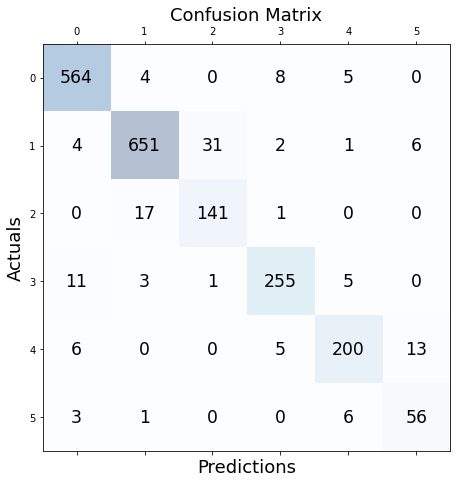

In [51]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y_label, y_test_pre)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

In [52]:
 from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(y_label, y_test_pre))
print(accuracy_score(y_label, y_test_pre))
print(emo_la)

              precision    recall  f1-score   support

         0.0       0.96      0.97      0.96       581
         1.0       0.96      0.94      0.95       695
         2.0       0.82      0.89      0.85       159
         3.0       0.94      0.93      0.93       275
         4.0       0.92      0.89      0.91       224
         5.0       0.75      0.85      0.79        66

    accuracy                           0.93      2000
   macro avg       0.89      0.91      0.90      2000
weighted avg       0.94      0.93      0.93      2000

0.9335
{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


In [53]:
# Save the model
torch.save(model.state_dict(), 'mobilebert_classification_model.pt')

In [72]:
def predict_emo(input_text):
    input_ids = tokenizer.encode(input_text, add_special_tokens=True, truncation=True, max_length=128)

    # Convert input_ids to a PyTorch tensor
    input_tensor = torch.tensor([input_ids]).to(device)

    # Make predictions on the input
    with torch.no_grad():
        outputs = model(input_tensor)
        logits = outputs[0]

    # Get the predicted label
    print(logits)
    predicted_label = torch.argmax(logits, dim=1).item()
    return emo_la[predicted_label]


In [73]:
predict_emo('get out of my way')


tensor([[-1.2349, -0.5416, -2.3633,  5.8220,  0.7344, -1.7210]],
       device='cuda:0')


'anger'

In [56]:
model.save_pretrained("emotion_predictor")
tokenizer.save_pretrained("emotion_predictor")

('emotion_predictor/tokenizer_config.json',
 'emotion_predictor/special_tokens_map.json',
 'emotion_predictor/vocab.txt',
 'emotion_predictor/added_tokens.json',
 'emotion_predictor/tokenizer.json')

In [57]:
print(torch.__version__)

1.11.0


In [58]:
pip install torch==1.9.0

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 831.4/831.4 MB 903.2 kB/s eta 0:00:0000:0100:01
  Attempting uninstall: torch
    Found existing installation: torch 1.11.0
    Uninstalling torch-1.11.0:
      Successfully uninstalled torch-1.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.10.0 requires protobuf==3.20.0, but you have protobuf 3.19.4 which is incompatible.
allennlp 2.10.0 requires torch<1.12.0,>=1.10.0, but you have torch 1.9.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [59]:
# import torch.nn.utils.prune as prune


# # Apply random pruning to the model
# prune.random_unstructured(model.classifier, name='weight', amount=0.5)

# # Remove pruned weights from the model
# prune.remove(model.classifier, 'weight')


In [60]:
def print_size_of_model(model):
    torch.save(model.state_dict(), "temp.p")
    print('Size (MB):', os.path.getsize("temp.p")/1e6)
    os.remove('temp.p')

print_size_of_model(model)

Size (MB): 99.861053


In [66]:
model.config

MobileBertConfig {
  "_name_or_path": "cambridgeltl/sst_mobilebert-uncased",
  "architectures": [
    "MobileBertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": true,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "problem_type": "single_label_classificat

In [63]:
!zip -r archive.zip /kaggle/working/emotion_predictor


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  adding: kaggle/working/emotion_predictor/ (stored 0%)
  adding: kaggle/working/emotion_predictor/tokenizer.json (deflated 71%)
  adding: kaggle/working/emotion_predictor/config.json (deflated 55%)
  adding: kaggle/working/emotion_predictor/pytorch_model.bin (deflated 7%)
  adding: kaggle/working/emotion_predictor/tokenizer_config.json (deflated 42%)
  adding: kaggle/working/emotion_predictor/special_tokens_map.json (deflated 42%)
  adding: kaggle/working/emotion_predictor/vocab.txt (deflated 53%)


In [65]:
# import torch

# # If there's a GPU available...
# if torch.cuda.is_available():    

#     # Tell PyTorch to use the GPU.    
#     device = torch.device("cuda")

#     print('There are %d GPU(s) available.' % torch.cuda.device_count())

#     print('We will use the GPU:', torch.cuda.get_device_name(0))

# # If not...
# else:
#     print('No GPU available, using the CPU instead.')
#     device = torch.device("cpu")
# import tensorflow as tf

# # Get the GPU device name.
# device_name = tf.test.gpu_device_name()

# # The device name should look like the following:
# if device_name == '/device:GPU:0':
#     print('Found GPU at: {}'.format(device_name))
# else:
#     raise SystemError('GPU device not found')

SyntaxError: invalid syntax (2061323700.py, line 1)